In [13]:
import autograd.numpy as anp
import numpy as np
import autograd
from autograd.extend import primitive, defvjp
import matplotlib.pyplot as plt
%matplotlib inline

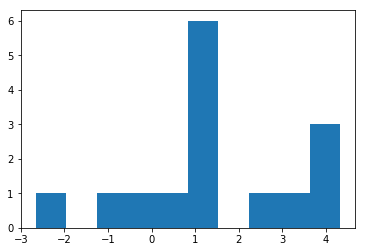

In [14]:
n = 15
p = np.array([0.2, 0.3, 0.5])
x = np.arange(len(p))
mus = np.array([0.0, 1.0, 4.0])
assignments = np.random.choice(x, size=n, p=p)
sd = 1
y = np.random.normal(loc = mus[assignments], scale=sd)

_ = plt.hist(y)

In [15]:
def sort_rows(z):
    perm = anp.argsort(z, axis=1)
    rows = anp.arange(z.shape[0], dtype=int).reshape(-1, 1)
    return z[rows, perm]

test = np.array([[1, 4, 2],
                 [8, 7, 5],
                 [2, -3, 1],
                 [-2, -10, 3]]).astype(float)

sort_rows(test), autograd.jacobian(sort_rows)(test)

(array([[  1.,   2.,   4.],
        [  5.,   7.,   8.],
        [ -3.,   1.,   2.],
        [-10.,  -2.,   3.]]), array([[[[1., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 0.],
          [0., 0.

In [16]:
def sparsemax_rows(z):
    ncols = z.shape[1]
    u = sort_rows(z)[:, ::-1]
    cssv = u.cumsum(axis=1) - 1
    ind = anp.arange(ncols) + 1
    cond = u - cssv / ind > 0
    argmin = anp.argmin(cond, axis=1)
    rho = np.where(argmin > 0, argmin, ncols)
    theta = cssv[anp.arange(z.shape[0]) , rho - 1]/rho
    return anp.clip(z - theta.reshape(-1, 1), 0, None)

sparsemax_rows(test), autograd.jacobian(sparsemax_rows)(test)

(array([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]), array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[

In [17]:
from autograd.scipy.stats import norm

rows = anp.arange(n)

def logp(assignments):
    return anp.sum(norm.logpdf(y, loc=mus[assignments], scale=sd) + anp.log(p)[assignments])

def logq(assignments, lambd):
    assignment_ps = sparsemax_rows(lambd)
    return anp.sum(anp.log(assignment_ps[rows, assignments]))
    
def entropy_q(lambd):
    assignment_ps = sparsemax_rows(lambd)
    nonzero_ps = assignment_ps[assignment_ps > 0]
    return anp.sum(nonzero_ps * -anp.log(nonzero_ps))
    
def sample_row_p(x, p):
    u = np.random.uniform(size=p.shape[0])
    pf = p.cumsum(axis=1)
    return np.argmax(u.reshape(-1, 1) < pf, axis=1)

def sample_q(lambd):
    p = sparsemax_rows(lambd)
    return sample_row_p(x, p)

# Approximate expectation w.r.t. dens(z; theta) of func(z) using samples[i = 1:s, ...] ~ dens(z; theta)

def score_function_estimator(func, sample, logdens_grad, theta):
    return func(sample)*logdens_grad(sample, theta)

entropy_grad = autograd.grad(entropy_q)
logq_grad = autograd.grad(logq, argnum=1)

def kl_grad(lambd, i):
    assignments = sample_q(lambd)
    return autograd.grad(entropy_q)(lambd) - score_function_estimator(logp, assignments, logq_grad, lambd)

kl_grad(np.random.normal(size=(n, 3)), 1)

array([[ -53.0570114 ,    0.        ,   53.0570114 ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [  88.66881793,  -45.61572435,  -43.05309359],
       [   0.        ,    0.        ,    0.        ],
       [ -48.93887606,    0.        ,   48.93887606],
       [ -77.49259208,  -79.56748018,  157.06007226],
       [   0.        ,  -50.71032014,   50.71032014],
       [ -57.51690619,    0.        ,   57.51690619],
       [ -78.06509639,   78.06509639,    0.        ],
       [ -95.02484407,   95.02484407,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,  120.11890785, -120.11890785],
       [   0.        ,   52.90032681,  -52.90032681],
       [   0.        ,    0.        ,    0.        ]])

In [18]:
lambd_init = np.zeros((n, len(p)))
kl_grad(lambd_init, 0)

array([[168.93725469, -84.46862735, -84.46862735],
       [-84.46862735, 168.93725469, -84.46862735],
       [-84.46862735, -84.46862735, 168.93725469],
       [168.93725469, -84.46862735, -84.46862735],
       [168.93725469, -84.46862735, -84.46862735],
       [-84.46862735, 168.93725469, -84.46862735],
       [-84.46862735, -84.46862735, 168.93725469],
       [168.93725469, -84.46862735, -84.46862735],
       [-84.46862735, 168.93725469, -84.46862735],
       [168.93725469, -84.46862735, -84.46862735],
       [168.93725469, -84.46862735, -84.46862735],
       [-84.46862735, -84.46862735, 168.93725469],
       [-84.46862735, 168.93725469, -84.46862735],
       [-84.46862735, 168.93725469, -84.46862735],
       [168.93725469, -84.46862735, -84.46862735]])

In [19]:
def get_callback(every):
    def callback(lambd, i, grad):
        if i % every == 0:
            assignments_ps = sparsemax_rows(lambd)
            print('Iteration {}'.format(i))
            print(assignments_ps)
    return callback

In [20]:
from autograd.misc.optimizers import rmsprop
        
res = rmsprop(kl_grad, lambd_init, callback=get_callback(1000), step_size=1e-3, num_iters=100000)
sparsemax_rows(res)

Iteration 0
[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]
Iteration 1000
[[0.37313059 0.32342611 0.30344329]
 [0.36418821 0.35254951 0.28326228]
 [0.29290914 0.38023585 0.32685501]
 [0.30058278 0.35852256 0.34089466]
 [0.33970138 0.32254581 0.33775281]
 [0.34282597 0.33463088 0.32254315]
 [0.31140536 0.40018839 0.28840626]
 [0.33793977 0.36548621 0.29657402]
 [0.34088543 0.33469153 0.32442303]
 [0.35912298 0.30250492 0.3383721 ]
 [0.30990053 0.31367274 0.37642674]
 [0.30235881 0.31952164 0.37811955]


Iteration 15000
[[0.37665256 0.33398167 0.28936577]
 [0.53186238 0.29963777 0.16849985]
 [0.32679788 0.37357885 0.29962327]
 [0.25115235 0.32864779 0.42019985]
 [0.33014238 0.3819788  0.28787882]
 [0.33892796 0.37595245 0.28511959]
 [0.46488732 0.35423674 0.18087594]
 [0.27259893 0.39056547 0.3368356 ]
 [0.14644883 0.27495311 0.57859806]
 [0.32685805 0.42347122 0.24967072]
 [0.19503377 0.22019195 0.58477428]
 [0.21064879 0.30887274 0.48047847]
 [0.42571285 0.36796378 0.20632337]
 [0.38678327 0.4176158  0.19560093]
 [0.1632013  0.27051773 0.56628097]]
Iteration 16000
[[0.39756262 0.34751455 0.25492284]
 [0.60828302 0.30996649 0.08175049]
 [0.3488391  0.3850009  0.26616   ]
 [0.24854967 0.33733017 0.41412016]
 [0.33936229 0.41311224 0.24752547]
 [0.36216948 0.39409269 0.24373782]
 [0.47894523 0.33857966 0.18247511]
 [0.220103   0.38233591 0.3975611 ]
 [0.15127725 0.27293717 0.57578558]
 [0.32430431 0.41952535 0.25617034]
 [0.26859813 0.17452526 0.55687661]
 [0.1892674  0.32343121 0.48730

Iteration 30000
[[0.31670192 0.47904959 0.20424849]
 [0.53949138 0.34300608 0.11750254]
 [0.26236344 0.43242511 0.30521145]
 [0.27681789 0.35575382 0.36742829]
 [0.23199967 0.53261764 0.2353827 ]
 [0.38996233 0.41859314 0.19144453]
 [0.44528728 0.36597201 0.18874071]
 [0.32829825 0.38379381 0.28790794]
 [0.14862222 0.24438295 0.60699483]
 [0.30360352 0.40472559 0.29167089]
 [0.17469383 0.25300545 0.57230072]
 [0.24918803 0.34087719 0.40993478]
 [0.39956349 0.40681203 0.19362448]
 [0.34087797 0.49316253 0.1659595 ]
 [0.17830988 0.21109028 0.61059984]]
Iteration 31000
[[0.34446861 0.46264335 0.19288804]
 [0.54431028 0.31437905 0.14131067]
 [0.2711171  0.47499958 0.25388332]
 [0.26982783 0.36742875 0.36274342]
 [0.22332491 0.55477251 0.22190257]
 [0.38038989 0.43881447 0.18079565]
 [0.37426269 0.36399722 0.26174008]
 [0.31854061 0.38809245 0.29336693]
 [0.15397579 0.26887488 0.57714933]
 [0.37112955 0.36586733 0.26300312]
 [0.14121383 0.28026246 0.5785237 ]
 [0.21183609 0.357294   0.43086

Iteration 45000
[[0.40999537 0.2915814  0.29842323]
 [0.63786739 0.23457483 0.12755778]
 [0.270062   0.52360485 0.20633315]
 [0.19455798 0.3074848  0.49795722]
 [0.26531312 0.46574801 0.26893887]
 [0.33654011 0.42946306 0.23399683]
 [0.50025389 0.36559576 0.13415035]
 [0.23935875 0.43711337 0.32352788]
 [0.17272063 0.22797215 0.59930722]
 [0.34191244 0.3836831  0.27440446]
 [0.10307119 0.2166934  0.68023541]
 [0.2250909  0.26412774 0.51078136]
 [0.35930992 0.48922839 0.15146169]
 [0.30806808 0.47607458 0.21585734]
 [0.16752463 0.20290507 0.6295703 ]]
Iteration 46000
[[0.38188521 0.34442917 0.27368562]
 [0.60529903 0.29092243 0.10377854]
 [0.26446396 0.5164771  0.21905894]
 [0.23902339 0.27403783 0.48693877]
 [0.33579286 0.46517589 0.19903125]
 [0.33773366 0.47108339 0.19118294]
 [0.48027403 0.35220756 0.1675184 ]
 [0.2302841  0.43387258 0.33584332]
 [0.17459214 0.2311258  0.59428206]
 [0.27230077 0.43242026 0.29527897]
 [0.16605507 0.2329846  0.60096033]
 [0.23093924 0.23066707 0.53839

Iteration 60000
[[0.39031411 0.34253635 0.26714954]
 [0.56724637 0.34191893 0.09083469]
 [0.41431754 0.36863408 0.21704839]
 [0.327858   0.25278349 0.41935851]
 [0.31566456 0.4266234  0.25771205]
 [0.33084732 0.49893866 0.17021402]
 [0.36697042 0.43939699 0.19363259]
 [0.37138219 0.3543697  0.2742481 ]
 [0.19494652 0.19626561 0.60878786]
 [0.35118522 0.44708524 0.20172955]
 [0.17945186 0.23845736 0.58209078]
 [0.2311268  0.25975779 0.50911541]
 [0.44259931 0.32184797 0.23555271]
 [0.40569272 0.374156   0.22015128]
 [0.13886031 0.23027709 0.63086259]]
Iteration 61000
[[0.38939006 0.30704059 0.30356935]
 [0.5785488  0.35906561 0.06238559]
 [0.38655709 0.33573516 0.27770775]
 [0.33193469 0.25934044 0.40872487]
 [0.31415016 0.40962879 0.27622105]
 [0.31587379 0.49965861 0.18446761]
 [0.32549918 0.43883764 0.23566318]
 [0.36684632 0.34041093 0.29274275]
 [0.18487375 0.21757653 0.59754972]
 [0.32434309 0.41652723 0.25912967]
 [0.15856655 0.25364358 0.58778987]
 [0.23095985 0.30352685 0.46551

Iteration 75000
[[0.25944346 0.44313784 0.2974187 ]
 [0.56419807 0.31216409 0.12363785]
 [0.38175409 0.3513508  0.26689512]
 [0.24310646 0.27489523 0.48199832]
 [0.3178161  0.39707165 0.28511225]
 [0.35680319 0.42751108 0.21568573]
 [0.33878326 0.48279551 0.17842123]
 [0.32085697 0.38381693 0.29532611]
 [0.15321816 0.16342252 0.68335932]
 [0.37064208 0.31958507 0.30977285]
 [0.18824776 0.20790601 0.60384624]
 [0.19208722 0.3223369  0.48557588]
 [0.4689197  0.35536264 0.17571767]
 [0.3820747  0.4404082  0.1775171 ]
 [0.13549283 0.18554357 0.67896359]]
Iteration 76000
[[0.33778602 0.40470266 0.25751132]
 [0.55406894 0.2822036  0.16372746]
 [0.40768865 0.37699957 0.21531178]
 [0.24767221 0.28504686 0.46728093]
 [0.32887877 0.37919792 0.29192331]
 [0.34100528 0.42441566 0.23457906]
 [0.30780121 0.52419037 0.16800842]
 [0.31419111 0.42178793 0.26402096]
 [0.2081116  0.14959514 0.64229326]
 [0.35489523 0.39257641 0.25252836]
 [0.2041225  0.19894442 0.59693308]
 [0.16733635 0.31606321 0.51660

Iteration 90000
[[0.37356113 0.41601484 0.21042403]
 [0.58097235 0.29126767 0.12775997]
 [0.27809123 0.38598605 0.33592272]
 [0.34576902 0.36118177 0.29304921]
 [0.36853155 0.32709557 0.30437288]
 [0.24163808 0.39673777 0.36162415]
 [0.40372208 0.37826908 0.21800884]
 [0.2721485  0.45069642 0.27715507]
 [0.18580038 0.23847242 0.57572719]
 [0.23762823 0.38206635 0.38030542]
 [0.1951775  0.21674315 0.58807935]
 [0.19724368 0.24105198 0.56170434]
 [0.47416351 0.32292501 0.20291148]
 [0.33129138 0.38624321 0.28246541]
 [0.16368882 0.15064485 0.68566633]]
Iteration 91000
[[0.29030533 0.43417956 0.2755151 ]
 [0.59758872 0.30534209 0.09706919]
 [0.31527252 0.40205572 0.28267176]
 [0.32472306 0.36945459 0.30582236]
 [0.35121974 0.34693052 0.30184974]
 [0.29202514 0.3697614  0.33821346]
 [0.40363769 0.40958554 0.18677677]
 [0.25965789 0.450245   0.29009711]
 [0.22394028 0.26416993 0.51188978]
 [0.22993845 0.42723578 0.34282577]
 [0.18853291 0.23155973 0.57990736]
 [0.1511929  0.26164927 0.58715

array([[0.36067786, 0.43984827, 0.19947387],
       [0.56350932, 0.30701298, 0.1294777 ],
       [0.25109091, 0.42340912, 0.32549998],
       [0.20134603, 0.37444817, 0.4242058 ],
       [0.37538036, 0.40592183, 0.21869782],
       [0.27089446, 0.45522059, 0.27388496],
       [0.46284137, 0.32831289, 0.20884574],
       [0.33250234, 0.40298461, 0.26451306],
       [0.18314761, 0.23251071, 0.58434168],
       [0.28367493, 0.36541145, 0.35091362],
       [0.15713694, 0.28192398, 0.56093909],
       [0.25876236, 0.34051995, 0.40071769],
       [0.38359908, 0.43596644, 0.18043448],
       [0.29569523, 0.41205758, 0.29224719],
       [0.2080226 , 0.24001991, 0.55195749]])

In [22]:
np.concatenate((sparsemax_rows(res), assignments.reshape(-1, 1), assignments.reshape(-1, 1)), axis=1)

array([[0.36067786, 0.43984827, 0.19947387, 1.        ],
       [0.56350932, 0.30701298, 0.1294777 , 0.        ],
       [0.25109091, 0.42340912, 0.32549998, 0.        ],
       [0.20134603, 0.37444817, 0.4242058 , 2.        ],
       [0.37538036, 0.40592183, 0.21869782, 1.        ],
       [0.27089446, 0.45522059, 0.27388496, 1.        ],
       [0.46284137, 0.32831289, 0.20884574, 1.        ],
       [0.33250234, 0.40298461, 0.26451306, 1.        ],
       [0.18314761, 0.23251071, 0.58434168, 2.        ],
       [0.28367493, 0.36541145, 0.35091362, 2.        ],
       [0.15713694, 0.28192398, 0.56093909, 2.        ],
       [0.25876236, 0.34051995, 0.40071769, 2.        ],
       [0.38359908, 0.43596644, 0.18043448, 0.        ],
       [0.29569523, 0.41205758, 0.29224719, 1.        ],
       [0.2080226 , 0.24001991, 0.55195749, 2.        ]])